In [14]:
####Training the network

<IPython.core.display.Javascript object>


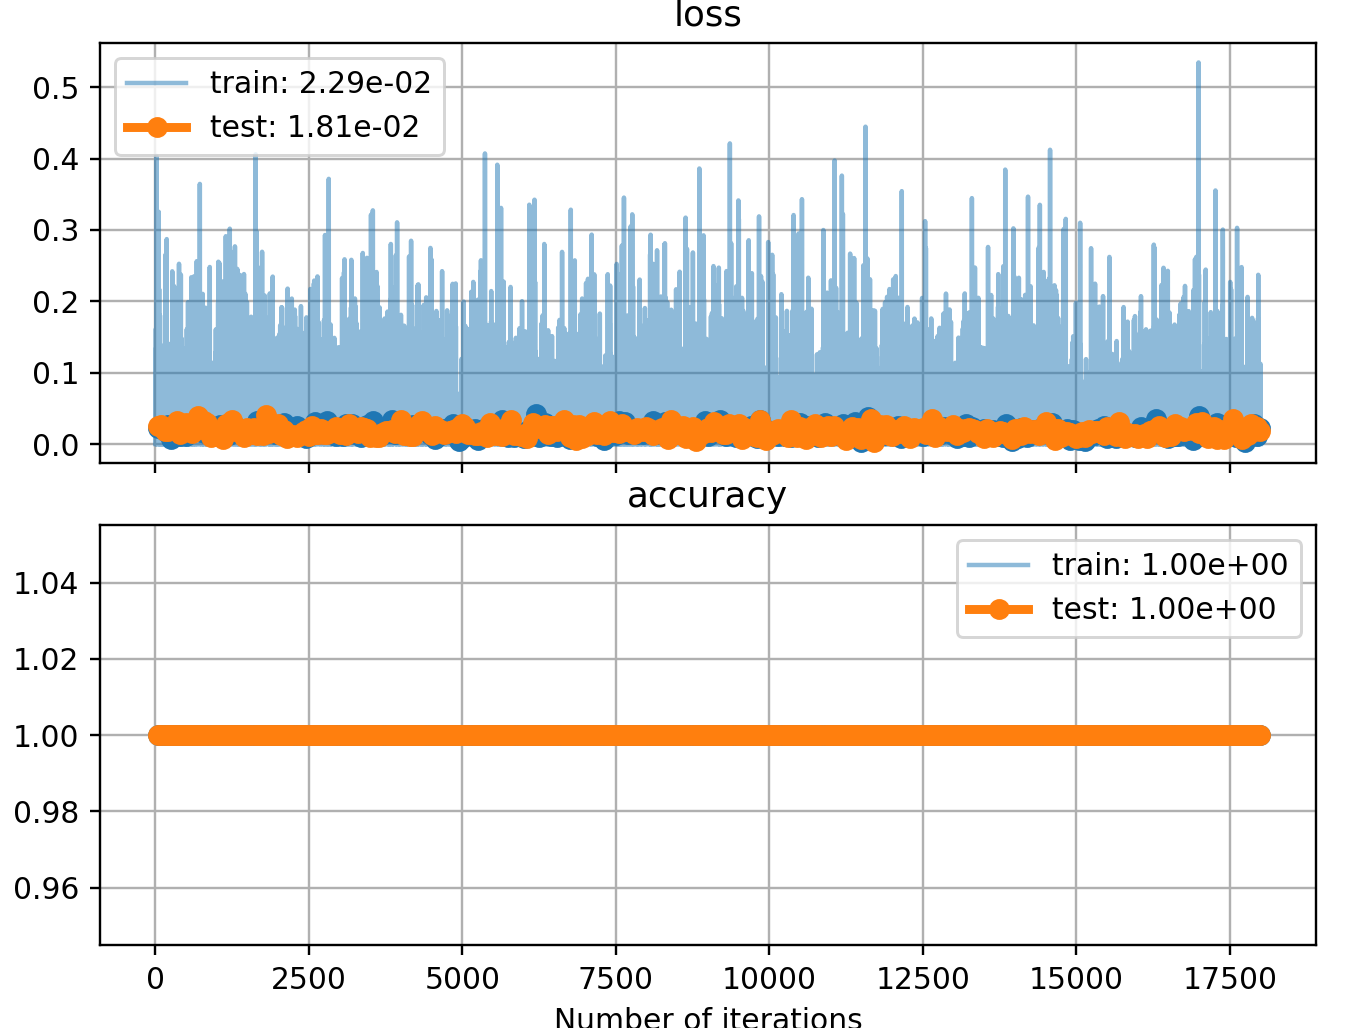

In [15]:
from liveplot import create_plot
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    ImportError
%matplotlib notebook
import matplotlib.pyplot as plt
plotter, fig, ax = create_plot(["loss", "accuracy"], refresh=5);

In [16]:
from mynn.initializers.normal import normal
from mynn.layers.dense import dense
import numpy as np
from mynn.optimizers.adam import Adam
from mygrad.nnet.losses import margin_ranking_loss 
import pickle
import mygrad as mg
###Our model class
class Model:
    def __init__(self):
        """
        Creates the dense layers
        """
        ##Creates a new dense thing and has the weights become the picture_dense layer
        self.picture_dense=dense(512, 50, weight_initializer= normal, bias=False)
        weights=np.load("picture_dense.npy")
        self.picture_dense.weight.data=weights
    def __call__(self, features):
        """
        Neural Network that uses the dense layer to matrix multiply to pic_fifty
        Parameters: 
            features: (1, 512) array of resnet features
        Returns:
            pic_fifty: (1, 50) array from the dense layers with the weights
        """
        pic_fifty=self.picture_dense(features)
        return pic_fifty
    def weights(self):
        weights=self.picture_dense.weight.data
        return weights
    @property
    def parameters(self):
        params = []
        layer=self.picture_dense
        params += list(layer.parameters)
        return params
def margin_ranking_Loss(prediction,truth,margin):
    return margin_ranking_loss(prediction,truth,1,margin)
import re, string
def strip_punc(corpus):
    punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))
    return punc_regex.sub('', corpus)
def training():
    model=Model()
    plot_every = 500
    batch_size=1
    optim = Adam(model.parameters)
    with open("resnet18_features_train.pkl", mode="rb") as opened_file:
        imgs_pickle=pickle.load(opened_file)
    with open("captions.pkl", mode="rb") as opened_file:
        captions_pickle=pickle.load(opened_file)
    with open("IDF.pkl", mode="rb") as opened_file:
        idf=pickle.load(opened_file)
    with open("embeddings.pkl", mode="rb") as opened_file:
        glove=pickle.load(opened_file) 
    train_imgs=np.zeros((68985, 512))
    train_captions=[]
    train_bad_img=np.zeros((68985, 512))
    test_imgs=np.zeros((len(imgs_pickle)-68984, 512))
    test_captions=[]
    test_bad_imgs=np.zeros((len(imgs_pickle)-68984, 512))
    imgs_pickle_keys=[i for i in imgs_pickle.keys()]
    imgs_pickle=[i for i in imgs_pickle.values()]
    for i in range(68985):
        train_imgs[i]=imgs_pickle[i]
        rand_int=np.random.randint(0, high=5)
        train_captions.append(captions_pickle[imgs_pickle_keys[i]][rand_int])
        bad_pic_index=np.random.randint(0, high=68985)
        if bad_pic_index==i:
            bad_pic_index+=1
        train_bad_img[i]=imgs_pickle[bad_pic_index]
    for i in range(68986, len(imgs_pickle)):
        test_imgs[i-68986]=imgs_pickle[i]
        rand_int=np.random.randint(0, high=5)
        test_captions.append(captions_pickle[imgs_pickle_keys[i]][rand_int])
        bad_pic_index=np.random.randint(68986, len(imgs_pickle))
        if bad_pic_index==i:
            bad_pic_index+=1
        test_bad_imgs[i-68986]=imgs_pickle[bad_pic_index]
    print("done making data")
    with open("stopwords.txt", 'r') as r:
        stops = []
        for line in r:
            stops += [i.strip() for i in line.split('\t')]
    for epoch_cnt in range(plot_every):
        idxs = np.arange(len(train_imgs))  # -> array([0, 1, ..., 9999])
        np.random.shuffle(idxs)  
        for batch_cnt in range(0, 50):#len(x_train)//batch_size):
            batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
            batch_good = train_imgs[batch_indices]  # random batch of our training data
            batch_bad = train_bad_img[batch_indices] 
            caption_idf=np.zeros((len(batch_indices), 50))
            for i, j in enumerate(batch_indices):
                caption_words=train_captions[j]
                caption = strip_punc(caption_words)
                caption=caption.lower()
                caption_list = caption.split()
                caption_idf_each_individual = np.zeros((50,))
                for w in caption_list:
                    if(not(w in stops) and (w in glove)):
                        caption_idf_each_individual += glove[w] * idf[w]
                caption_idf[i]=caption_idf_each_individual
            
            #for i in range(batch_size)
            
            # compute the predictions for this batch by calling on model
            prediction_good = model(batch_good)
            prediction_bad = model(batch_bad)
            #Normalized it
            for i in range(batch_size):
                prediction_good[i]=prediction_good[i]/mg.sqrt(mg.sum(prediction_good[i]**2))
                prediction_bad[i]=prediction_bad[i]/mg.sqrt(mg.sum(prediction_bad[i]**2))
                caption_idf[i]=caption_idf[i]/mg.sqrt(mg.sum(caption_idf[i]**2))
            
            caption_idf_reversed=caption_idf.T

            # compute the true (a.k.a desired) values for this batch: 
            good=mg.matmul(prediction_good, caption_idf_reversed)
            bad=mg.matmul(prediction_bad, caption_idf_reversed)
            # compute the loss associated with our predictions(use softmax_cross_entropy)
            loss = margin_ranking_Loss(good, bad, .1)
            # back-propagate through your computational graph through your loss
            loss.backward()

            # compute the accuracy between the prediction and the truth 
            acc = 1

            # execute gradient descent by calling step() of optim
            optim.step()
            weights=model.weights()
            

            # null your gradients (please!)
            loss.null_gradients()

            # set the training loss and accuracy
            plotter.set_train_batch({"loss" : loss.item(),
                                     "accuracy" : acc},
                                     batch_size=batch_size)
        plotter.plot_train_epoch()
        # Here, we evaluate our model on batches of *testing* data
        # this will show us how good our model does on data that 
        # it has never encountered
        # Iterate over batches of *testing* data
        idxs_test = np.arange(len(test_imgs)-2)  # -> array([0, 1, ..., 9999])
        np.random.shuffle(idxs_test)  
        for batch_cnt in range(0, 50):#len(x_train)//batch_size):
            batch_indices = idxs_test[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
            batch_good = test_imgs[batch_indices]  # random batch of our training data
            batch_bad = test_bad_imgs[batch_indices] 
            caption_idf=np.zeros((len(batch_indices), 50))
            for i, j in enumerate(batch_indices):
                caption_words=test_captions[j]
                caption = strip_punc(caption_words)
                caption=caption.lower()
                caption_list = caption.split()
                caption_idf_each_individual = np.zeros((50,))
                for w in caption_list:
                    if(not(w in stops) and (w in glove)):
                        caption_idf_each_individual += glove[w] * idf[w]
                caption_idf[i]=caption_idf_each_individual
            
            #for i in range(batch_size)
            
            # compute the predictions for this batch by calling on model
            prediction_good = model(batch_good)
            prediction_bad = model(batch_bad)
            #Normalized it
            for i in range(batch_size):
                prediction_good[i]=prediction_good[i]/mg.sqrt(mg.sum(prediction_good[i]**2))
                prediction_bad[i]=prediction_bad[i]/mg.sqrt(mg.sum(prediction_bad[i]**2))
                caption_idf[i]=caption_idf[i]/mg.sqrt(mg.sum(caption_idf[i]**2))
            
            caption_idf_reversed=caption_idf.T

            # compute the true (a.k.a desired) values for this batch: 
            good=mg.matmul(prediction_good, caption_idf_reversed)
            bad=mg.matmul(prediction_bad, caption_idf_reversed)
            # compute the loss associated with our predictions(use softmax_cross_entropy)
            loss = margin_ranking_Loss(good, bad, .1)
            
            # compute the accuracy between the prediction and the truth 
            acc = 1


            # set the training loss and accuracy
            plotter.set_test_batch({"loss" : loss.item(),
                                     "accuracy" : acc},
                                     batch_size=batch_size)
        # this tells liveplot to plot the epoch-level train/test statistics :)
        plotter.plot_test_epoch()
        np.save("picture_dense.npy", weights)

In [ ]:
training()

done making data


In [ ]:
diction = {}
for val in range(10):
    diction[val] =  [1,2,3]
diction

In [69]:
diction[0][0]

1

In [120]:
with open("embeddings.pkl", mode="rb") as opened_file:
    glove=pickle.load(opened_file) 
"blackand" in glove

False

In [5]:
model=Model()
    plot_every = 500
    batch_size=350
    optim = Adam(model.parameters)
    with open("resnet18_features_train.pkl", mode="rb") as opened_file:
        imgs_pickle=pickle.load(opened_file)
    with open("captions.pkl", mode="rb") as opened_file:
        captions_pickle=pickle.load(opened_file)
    with open("IDF.pkl", mode="rb") as opened_file:
        idf=pickle.load(opened_file)
    with open("embeddings.pkl", mode="rb") as opened_file:
        glove=pickle.load(opened_file) 
    train_imgs=np.zeros((68985, 512))
    train_captions=[]
    train_bad_img=np.zeros((68985, 512))
    test_imgs=np.zeros((len(imgs_pickle)-68984, 512))
    test_captions=[]
    imgs_pickle_keys=[i for i in imgs_pickle.keys()]
    imgs_pickle=[i for i in imgs_pickle.values()]
    for i in range(68985):
        train_imgs[i]=imgs_pickle[i]
        rand_int=np.random.randint(0, high=5)
        train_captions.append(captions_pickle[imgs_pickle_keys[i]][rand_int])
        bad_pic_index=np.random.randint(0, high=68985)
        if bad_pic_index==i:
            bad_pic_index+=1
        train_bad_img[i]=imgs_pickle[bad_pic_index]
    for i in range(68986, len(imgs_pickle)):
        test_imgs[i-68984]=imgs_pickle[i]
        rand_int=np.random.randint(0, high=5)
        test_captions.append(captions_pickle[imgs_pickle_keys[i]][rand_int])
    with open("stopwords.txt", 'r') as r:
        stops = []
        for line in r:
            stops += [i.strip() for i in line.split('\t')]
    for epoch_cnt in range(plot_every):
        idxs = np.arange(len(train_imgs))  # -> array([0, 1, ..., 9999])
        np.random.shuffle(idxs)  
        for batch_cnt in range(0, len(train_imgs)//batch_size):#len(x_train)//batch_size):
            batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
            batch_good = train_imgs[batch_indices]  # random batch of our training data
            batch_bad = train_bad_img[batch_indices] 
            caption_idf=np.zeros((len(batch_indices), 50))
            for i, j in enumerate(batch_indices):
                caption_words=train_captions[j]
                caption = strip_punc(caption_words)
                caption=caption.lower()
                caption_list = caption.split()
                caption_idf_each_individual = np.zeros((50,))
                for w in caption_list:
                    if(not(w in stops) and (w in glove)):
                        caption_idf_each_individual += glove[w] * idf[w]
                caption_idf[i]=caption_idf_each_individual
            
            #for i in range(batch_size)
            
            # compute the predictions for this batch by calling on model
            prediction_good = model(batch_good)
            prediction_bad = model(batch_bad)
            #Normalized it
            prediction_good=prediction_good/mg.sqrt(mg.sum(prediction_good**2))
            prediction_bad=prediction_bad/mg.sqrt(mg.sum(prediction_bad**2))
            caption_idf=caption_idf/mg.sqrt(mg.sum(caption_idf**2))
            
            
            caption_idf_reversed=caption_idf.T

            # compute the true (a.k.a desired) values for this batch: 
            good=mg.matmul(prediction_good, caption_idf_reversed)
            bad=mg.matmul(prediction_bad, caption_idf_reversed)
            return (good, bad)
            # compute the loss associated with our predictions(use softmax_cross_entropy)
            loss = margin_ranking_Loss(good, bad, .2)
            # back-propagate through your computational graph through your loss
            loss.backward()

            # compute the accuracy between the prediction and the truth 
            acc = 1

            # execute gradient descent by calling step() of optim
            optim.step()
            weights=model.weights()
            

            # null your gradients (please!)
            loss.null_gradients()

            # set the training loss and accuracy
            plotter.set_train_batch({"loss" : loss.item(),
                                     "accuracy" : acc},
                                     batch_size=batch_size)

        # Here, we evaluate our model on batches of *testing* data
        # this will show us how good our model does on data that 
        # it has never encountered
        # Iterate over batches of *testing* data
        for batch_cnt in range(0, len(train_imgs)//batch_size):#len(x_train)//batch_size):
            batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
            batch_good = train_imgs[batch_indices]  # random batch of our training data
            batch_bad = train_bad_img[batch_indices] 
            caption_idf=np.zeros([batch_indices.shape[0], 50])
            for i, j in enumerate(batch_indices):
                caption_words=train_captions[j] 
                caption = strip_punc(caption_words)
                caption=caption.lower()
                caption_list = caption.split()
                caption_idf_each_individual = np.zeros((50,))
                for w in caption_list:
                    if(not(w in stops) and (w in glove)):
                        caption_idf_each_individual += glove[w] * idf[w]
                caption_idf[i]=caption_idf_each_individual
            #for i in range(batch_size)
            
            # compute the predictions for this batch by calling on model
            prediction_good = model(batch_good)
            prediction_bad = model(batch_bad)

            #Normalized it
            prediction_good=prediction_good/mg.sqrt(mg.sum(prediction_good**2))
            prediction_bad=prediction_bad/mg.sqrt(mg.sum(prediction_bad**2))
            caption_idf=caption_idf/mg.sqrt(mg.sum(caption_idf**2))
            
            caption_idf_reversed=caption_idf.T
            # compute the true (a.k.a desired) values for this batch: 
            good=mg.matmul(prediction_good, caption_idf_reversed)
            bad=mg.matmul(prediction_bad, caption_idf_reversed)
            
            # compute the loss associated with our predictions(use softmax_cross_entropy)
            loss = margin_ranking_Loss(good, bad, .2)

            # compute the accuracy between the prediction and the truth 
            acc = 1

            # set the training loss and accuracy
            plotter.set_test_batch({"loss" : loss.item(),
                                     "accuracy" : acc},
                                     batch_size=batch_size)
        # this tells liveplot to plot the epoch-level train/test statistics :)
        plotter.plot_test_epoch()
        plotter.plot_train_epoch()

IndentationError: unexpected indent (<ipython-input-5-4601909353d9>, line 2)